[![General Assembly Logo](https://camo.githubusercontent.com/1a91b05b8f4d44b5bbfb83abac2b0996d8e26c92/687474703a2f2f692e696d6775722e636f6d2f6b6538555354712e706e67)](https://generalassemb.ly/education/web-development-immersive)
![Misk Logo](https://i.ibb.co/KmXhJbm/Webp-net-resizeimage-1.png)  
<h1 style = 'color:#f2d53c'> CapeStone: Genrate Faces with   Generative Adversarial Network </h1>


In [90]:
import tensorflow as tf
# using gpu because it take less time 
# check of our GPU
device_name = tf.test.gpu_device_name() # gpu 
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [91]:
# import needed libary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import cv2
import os
import time
import imutils
np.set_printoptions(precision=4) 
    
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


<h1 style = 'color:#f2d53c'> The Dataset </h1>
We have three image dataset  containg Faces (anime, human and simpson )

In [92]:
# read files 
# anime
image = tf.io.read_file('data/1.png')
image = tf.image.decode_png(image, channels=3)
# human
image2 = tf.io.read_file(glob.glob('real/*.png')[10])
image2 = tf.image.decode_png(image2, channels=3)

# simpson 
image3 = tf.io.read_file('cropped/100.png')
image3 = tf.image.decode_png(image3, channels=3)




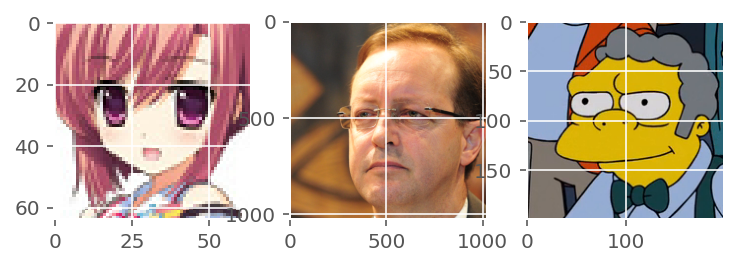

In [93]:
# plot  some images 
fig, ax = plt.subplots(1,3)
ax[0].imshow(image)
ax[1].imshow(image2)
ax[2].imshow(image3)

In [94]:
def resize_image(image):
    """
    this function is going to process images that comes from read image function 
    to process it for useing it in the model"""
    image = tf.image.resize(image, (64, 64)) # to make sure that they in the same size 
    image = tf.cast(image, tf.float32) # turn into float32
    image = (image / 127.5) - 1  # make the values between 1 to - 1 
    return image 
    
    

In [95]:
def read_images(src):
        """
        reading the image from the file_path
        """
        image = tf.io.read_file(src)
        image = tf.image.decode_png(image, channels=3)
        image = resize_image(image)
        return image 


In [96]:
# taking all images all image we have ends with png
image_path = glob.glob('data/*.png')
image_path2 = glob.glob('real/*.png')
image_path3 = glob.glob('cropped/*.png')

In [97]:
print(f' the lenght of the images  is Anime: {len(image_path)} Human:  {len(image_path2)}  Simpson: {len(image_path3)} total {len(image_path) + len(image_path2) + len(image_path3)}')

 the lenght of the images  is Anime: 21551 Human:  7844  Simpson: 9876 total 39271


In [98]:
# Create a source dataset from your input data.
# Apply dataset transformations to preprocess the data.
# Iterate over the dataset and process the elements.
#  we want to pass it to tensorflow.
image = tf.data.Dataset.from_tensor_slices(image_path)
image2 = tf.data.Dataset.from_tensor_slices(image_path2)
image3 = tf.data.Dataset.from_tensor_slices(image_path3)

In [99]:
image = image.map(read_images)
image2 = image2.map(read_images)
image3 = image3.map(read_images)

In [100]:
BATCH_SIZE = 50 

In [101]:
# Randomly shuffles the elements of this dataset
# Prefetching overlaps the preprocessing and model execution of a training step.
image = image.shuffle(len(glob.glob('data/*.png'))).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
image2 = image2.shuffle(len(glob.glob('real/*.png'))).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
image3 = image3.shuffle(len(glob.glob('cropped/*.png'))).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

<h1 style = 'color:#f2d53c'> Bulding GAN </h1>


- replace pooling layer with Conv2DTranspose 
- use BatchNormalization in both g and disc expect for gen  outpot layer and dis input layer 
-  genrator activtion should be LeakyReLU or ReLU expect output layer we use tanh 
- all layers in disc shplud use LeakyReLU or ReLU



<a href ='https://arxiv.org/abs/1511.06434'> check this paper </a> 

how dose it work 

<img src = 'how.jpg'/>


#### Buliding The Generator 

In [102]:
generator = tf.keras.Sequential([
 
     tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)), # takes coding size 100 and prject them to 16384 dim 
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Reshape((8, 8, 256)),  # reshape it 8x8x256

    
     tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False), # 
     tf.keras.layers.BatchNormalization(), # stride * (8x8x256) =(8x8x128)
     tf.keras.layers.LeakyReLU(),            
    
     tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False), # 16x16x64
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),           
    
     tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False), # 32x32x32
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),            
     tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')]) # 64x64x3

#### Buliding The Discriminator

In [103]:
discriminator = tf.keras.Sequential([
  
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Dropout(0.3),     

     tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Dropout(0.3),    
    
     tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
    
     tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),      

     tf.keras.layers.Dropout(0.3),
    
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1024),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Dense(1)]) 

In [104]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_24 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 8, 8, 128)        

In [105]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)       

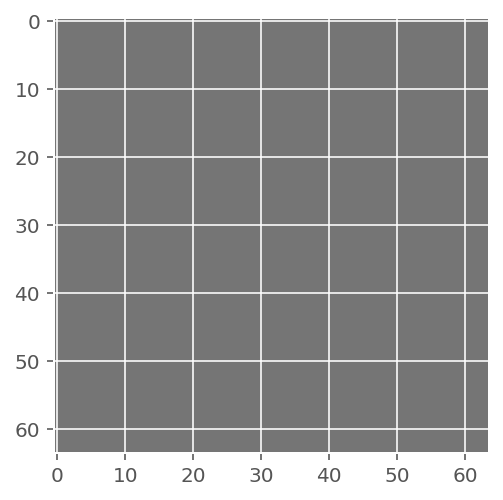

In [106]:
# noise that we are going to use to make fake images 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0] + 255)/555);

In [107]:
feedback = discriminator(generated_image)
print(feedback)

tf.Tensor([[0.001]], shape=(1, 1), dtype=float32)


In [108]:
# the loss function we are going to use 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [109]:
def discriminator_loss(real_output, fake_output):
    """Discriminator loss
       This method quantifies how well the discriminator is able to distinguish real images from fakes."""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1 for real images 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 0 for fake images 
    total_loss = real_loss + fake_loss
    return total_loss

In [110]:
def generator_loss(fake_output):
    """The generator loss quantifies how well it was able to trick the discriminator."""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [111]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [112]:
# save the model (checkpoint)
checkpoint_dir = './'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [113]:
EPOCHS = 800
noise_dim = 100
num_examples_to_generate = 4

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [114]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # GradientTape opreation are recaorded 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # feedit to prduce fake images 
        # phase 1 : traning the discre on real and fake image 
        real_output = discriminator(images, training=True)  # from real dataset
        fake_output = discriminator(generated_images, training=True) # from genrator fake images 
        # update gen and dis 
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # return traible varible when the training  wasTrue
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [133]:
def generateimages(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')
    plt.show()

In [134]:
def train(dataset, epochs):
    start = time.time()
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        if epoch%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print(f'the time for {epoch} is {time.time()-start} ')
            generateimages(generator,
                                     epoch + 1,
                                     seed)


    generateimages(generator,
                           epochs,
                           seed)

<h1 style = 'color:#f2d53c'> Results </h1>


the time for 0 is 85.83003377914429 


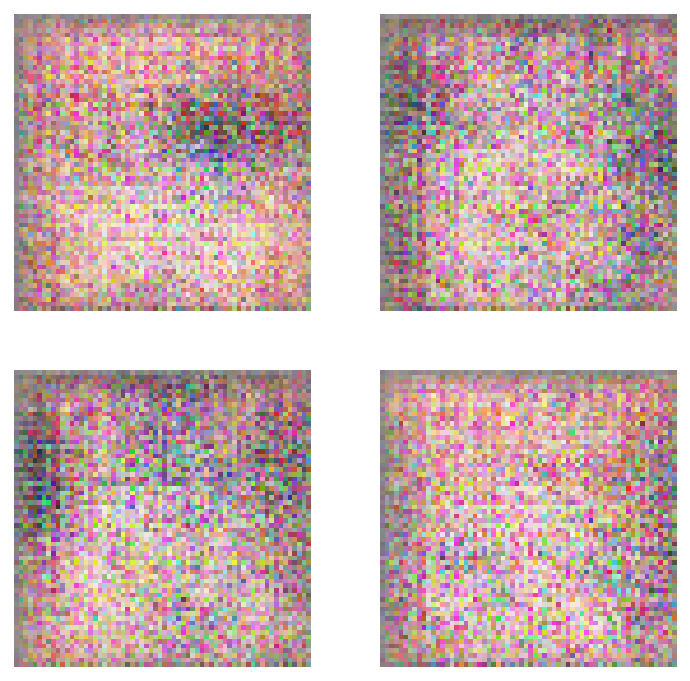

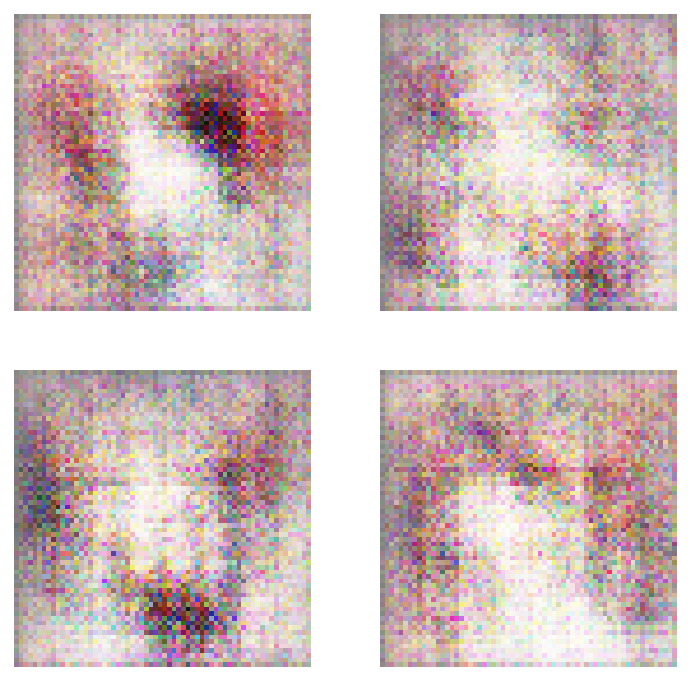

In [136]:
train(image, EPOCHS)


In [ ]:
train(image3, EPOCHS)
